In [200]:
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis as cfv
import calfem.vis_mpl as cfvl
import numpy as np

### Define Geometry

In [201]:
g = cfg.Geometry()

g.point([0.0, 0.0]) # point 0
g.point([1.0, 0.0]) # point 1
g.point([1.0, 1.0]) # point 2
g.point([0.0, 1.0]) # point 2

g.spline([0, 1], marker=0) # line 0
g.spline([1, 2], marker=1) # line 1
g.spline([2, 3], marker=0) # line 2
g.spline([3, 0], marker=1) # line 3

g.surface([0, 1, 2, 3])


### Generate Mesh

In [202]:
def reshape_boundary_dict(bdofs):
    nodeset = set([0])
    for array in bdofs.items():
        nodeset.update(array[1])
    new = np.zeros(len(nodeset)-1)
    for key in bdofs:
        for elem in bdofs[key]:
            new[elem-1] = key
    return new

In [203]:
mesh = cfm.GmshMesh(g)
mesh.elType = 2          # Degrees of freedom per node.
mesh.dofsPerNode = 1     # Factor that changes element sizes.
mesh.elSizeFactor = 0.1 # Element size Factor
coords, edof, dofs, bdofs, elementmarkers = mesh.create()
boundary_voltages = reshape_boundary_dict(bdofs)
print(boundary_voltages)
print(bdofs)

Info    : GMSH -> Python-module
[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
{0: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 23, 24, 25, 26, 27, 28, 29, 30, 31], 1: [1, 2, 3, 4, 14, 15, 16, 17, 18, 19, 20, 21, 22, 32, 33, 34, 35, 36, 37, 38, 39, 40]}


### Assemble Element Matrices

In [204]:
def Ke(coords, alpha_x, alpha_y):
    x1 = coords[0,0]
    x2 = coords[1,0]
    x3 = coords[2,0]
    y1 = coords[0,1]
    y2 = coords[1,1]
    y3 = coords[2,1]
    A = 1/2 * np.abs(x1*(y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    M11 = -(alpha_x * (y2 - y3) ** 2  + alpha_y * (x3 - x2) ** 2) / (4 * A)
    M12 = -(alpha_x * (y2 - y3) * (y3 - y1) + alpha_y * (x3 - x2) * (x1 - x3)) / (4 * A)
    M13 = -(alpha_x * (y2 - y3) * (y1 - y2) + alpha_y * (x3 - x2) * (x2 - x1)) / (4 * A)
    M22 = -(alpha_x * (y3 - y1) ** 2 + alpha_y * (x1 - x3) ** 2) / (4 * A)
    M23 = -(alpha_x * (y3 - y1) * (y1 - y2) + alpha_y * (x1 - x3) * (x2 - x1)) / (4 * A)
    M33 = -(alpha_x * (y1 - y2) ** 2 + alpha_y * (x2 - x1) ** 2) / (4 * A)
    return np.matrix([[M11, M12, M13],
                      [M12, M22, M23],
                      [M13, M23, M33]])

In [205]:
num_elem = len(edof)
num_nodes = len(dofs)
ke = np.zeros((num_elem, 3, 3))
for i in range(num_elem):
    ke[i] = Ke(coords[edof[i] - 1], 1, 1)

### Assemble Global Matrix

In [206]:
K = np.zeros((num_nodes, num_nodes))
for e in range(num_elem):
    for i in range(3):
        for j in range(3):
            K[edof[e,i] - 1, edof[e,j] - 1] += ke[e,i,j]

### Create RHS Vector

In [207]:
b = np.zeros(num_nodes)

### Introduce Boundary Conditions

In [208]:
for n in reversed (range(len(boundary_voltages))):
    for i in range(len(b)):
        b[i] -= boundary_voltages[n]*K[i, n]
    b = np.delete(b, n, axis=0)
    K = np.delete(K, n, axis=0)
    K = np.delete(K, n, axis=1)

### Solve

In [209]:
x = np.linalg.solve(K,b)
v = np.zeros(num_nodes-len(x))
v = np.concatenate((boundary_voltages,x))

### Plot

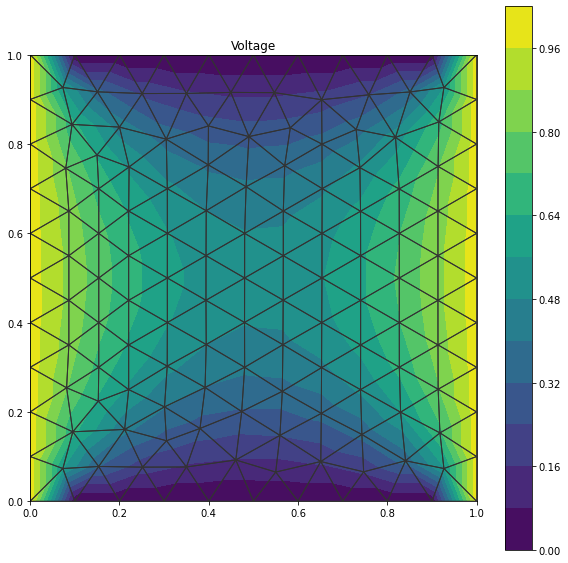

In [210]:
cfvl.figure(fig_size=(10,10))
cfvl.draw_nodal_values_contourf(v, coords, edof, title="Voltage", dofs_per_node=mesh.dofs_per_node, el_type=mesh.el_type, draw_elements=True)
cfvl.colorbar()